# Chargement des données

Dans mon projet, j'ai choisi de classifier des images associées à 5 labels différents : **vintage**, **classique**, **gothique**, **streetwear** et **chic**.

J'ai réparti mes images dans 3 ensembles (et donc 3 dossiers): *train*, *validation* et *test*. Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes. L'arborescence est résumée sur l'image ci-dessus.

J'ai choisi d'héberger ma base de données sur Github : l'intérêt est qu'un **git clone** depuis Google Colab est très rapide, ce qui vous garantit une certaine simplicité. Je vous encourage à en faire de même.

In [1]:
!git clone https://github.com/TItygrosminet/Projet_Deep_Learning.git
path = "./Projet_Deep_Learning/src/"

Cloning into 'Projet_Deep_Learning'...
remote: Enumerating objects: 9184, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 9184 (delta 8), reused 9 (delta 2), pack-reused 9163
Receiving objects: 100% (9184/9184), 459.64 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (12780/12780), done.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [2]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

import cv2


def load_data(data_path, classes, dataset, image_size=75):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = cv2.imread(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = cv2.resize(img, (image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [3]:
labels = ['vintage', 'classique', 'gothique', 'streetwear', 'chic']

x, y = load_data(path, labels, dataset='cropped_images', image_size=75)
print(x.shape, y.shape)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x = x/255

from sklearn.model_selection import train_test_split

x_train, x_gen, y_train, y_gen = train_test_split(x,y, test_size = 3/10)
x_val, x_test, y_val, y_test = train_test_split(x_gen,y_gen, test_size = 1/2)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape


(4230, 75, 75, 3) (4230, 1)


((2961, 75, 75, 3),
 (634, 75, 75, 3),
 (635, 75, 75, 3),
 (2961, 1),
 (634, 1),
 (635, 1))

In [4]:
import pandas as pd

# créer un DataFrame pour stocker les résultats
data = {'classe': labels,
        'train': pd.Series(y_train.ravel()).value_counts(),
        'val': pd.Series(y_val.ravel()).value_counts(),
        'test': pd.Series(y_test.ravel()).value_counts()}

df = pd.DataFrame(data)

print(df)

         classe  train  val  test
0.0     vintage    551  122   120
1.0   classique    691  149   140
2.0    gothique    614  135   133
3.0  streetwear    623  128   125
4.0        chic    482  100   117


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

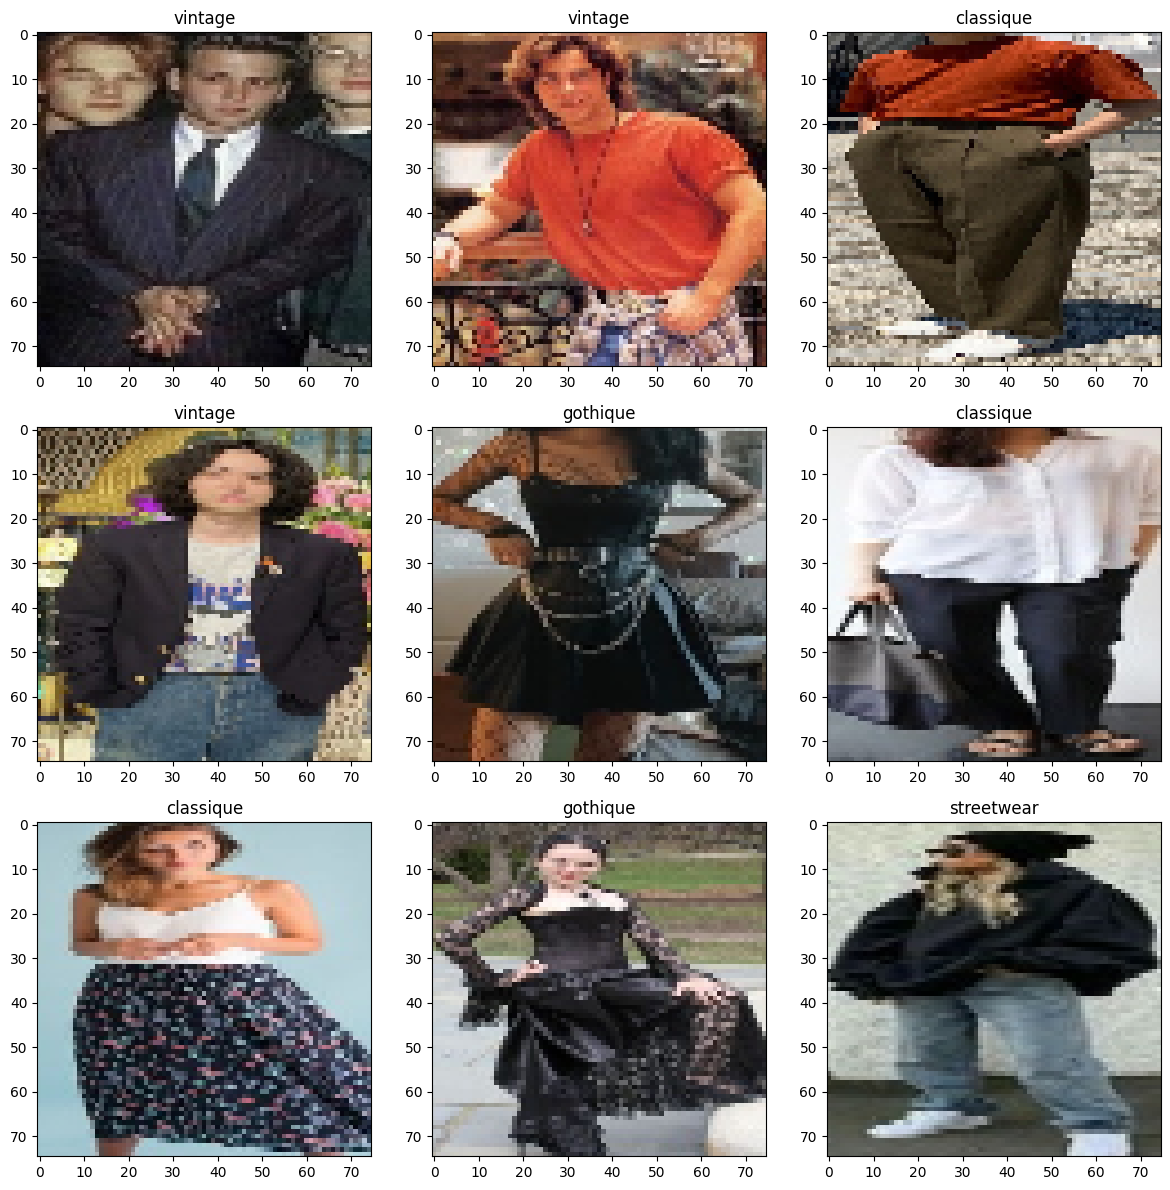

In [5]:
import matplotlib.pyplot as plt
from random import randint
plt.figure(figsize=(12, 12))
shuffle_indices = [randint(0, x.shape[0]) for i in range(9)]
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x[shuffle_indices[i]]
    plt.title(labels[int(y[shuffle_indices[i]])])
    plt.imshow(image)

plt.tight_layout()
plt.show()

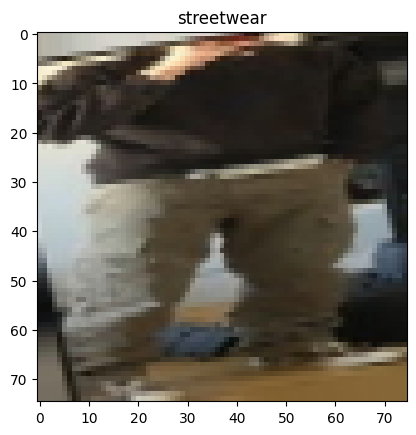

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,          # Randomly flip images horizontally
    rotation_range=10,             # Randomly rotate images by up to 20 degrees
)

example_x, example_y = train_datagen.flow(x_train, y_train, batch_size=1).next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(labels[int(example_y[i])])
    plt.show()

In [7]:
from tensorflow.keras.applications import ResNet50, VGG16, Xception, NASNetMobile, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

# Define your convolution bases
conv_bases = [ResNet50, VGG16, Xception, NASNetMobile, MobileNetV2]

# Define a function to create and compile your models
def create_model(conv_base):
    # Instantiate the convolution base
    base = conv_base(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
    
    # Freeze the convolution base layers
    for layer in base.layers:
        layer.trainable = False
    
    # Build your model on top of the convolution base
    x = Flatten()(base.output)
    x = Dense(512, activation='relu', kernel_regularizer='l1')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [8]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Define the early stopping callback
es = EarlyStopping(
    min_delta=0.001,
    patience=20,
)

# Train and evaluate each model with early stopping
results = {}
for conv_base in conv_bases:
    model = create_model(conv_base)
    history = model.fit(x_train, y_train, batch_size=10, validation_data=(x_val, y_val), epochs=200, callbacks=[es])
    test_loss, test_acc = model.evaluate(x_test, y_test)
    results[conv_base.__name__] = test_acc * 100
    model.save(f'{conv_base.__name__}.h5')

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/200
297/297 [==============================] - 19s 26ms/step - loss: 67.7843 - accuracy: 0.2432 - val_loss: 5.6698 - val_accuracy: 0.2397
Epoch 2/200
297/297 [==============================] - 5s 18ms/step - loss: 5.4337 - accuracy: 0.2303 - val_loss: 5.2592 - val_accuracy: 0.2650
Epoch 3/200
297/297 [==============================] - 5s 17ms/step - loss: 5.2259 - accuracy: 0.2222 - val_loss: 5.1613 - val_accuracy: 0.2271
Epoch 4/200
297/297 [==============================] - 5s 18ms/step - loss: 5.1658 - accuracy: 0.2486 - val_loss: 5.1384 - val_accuracy: 0.2681
Epoch 5/200
297/297 [==============================] - 5s 17ms/step - loss: 5.1215 - accuracy: 0.2408 - val_loss: 5.0668 - val_accuracy: 0.2366
Epoch 6/200
297/297 [==============================] - 6s 19ms/step - loss: 5.1181 - accuracy: 0.2442 - val_loss: 5.1489 - val_accuracy: 0.2366
Epoch 7/200
297/297 [==============================] - 5s 17ms/step -

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/200
297/297 [==============================] - 9s 18ms/step - loss: 112.9334 - accuracy: 0.4958 - val_loss: 11.4495 - val_accuracy: 0.2713
Epoch 2/200
297/297 [==============================] - 3s 10ms/step - loss: 10.9871 - accuracy: 0.4387 - val_loss: 10.8829 - val_accuracy: 0.2603
Epoch 3/200
297/297 [==============================] - 3s 10ms/step - loss: 9.7259 - accuracy: 0.4306 - val_loss: 9.3968 - val_accuracy: 0.4038
Epoch 4/200
297/297 [==============================] - 3s 11ms/step - loss: 8.8049 - accuracy: 0.4363 - val_loss: 7.9151 - val_accuracy: 0.3249
Epoch 5/200
297/297 [==============================] - 3s 11ms/step - loss: 7.7785 - accuracy: 0.4455 - val_loss: 7.7715 - val_accuracy: 0.4006
Epoch 6/200
297/297 [==============================] - 3s 9ms/step - loss: 7.0111 - accuracy: 0.4671 - val_loss: 7.0022 - val_accuracy: 0.4117
Epoch 7/200
297/297 [==============================] - 3s 10ms/step -

<ipython-input-9-71b64aed66c2>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(results.keys(), fontsize=8)


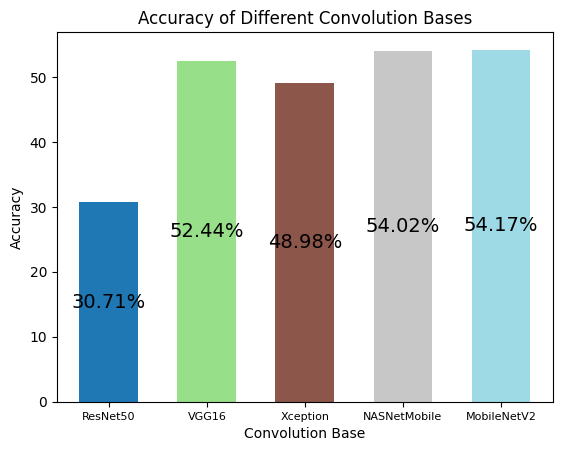

In [9]:
# Define colors for each bar
colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

# Plot the results
fig, ax = plt.subplots()
rects = ax.bar(results.keys(), results.values(), color=colors, width=0.6)
ax.set_title('Accuracy of Different Convolution Bases')
ax.set_xlabel('Convolution Base')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(results.keys(), fontsize=8)
for rect, acc in zip(rects, results.values()):
    width = rect.get_width()
    height = rect.get_height()
    x = rect.get_x() + width / 2
    y = rect.get_y() + height / 2
    ax.text(x, y, f'{acc:.2f}%', ha='center', va='center', fontsize=14)
plt.show()

In [10]:
from tensorflow.keras.models import load_model

results = {}
for conv_base in conv_bases:
    model = load_model(f'{conv_base.__name__}.h5')
    for layer in model.layers[:-4]:
        layer.trainable = True
    
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=10, validation_data=(x_val, y_val), epochs=200, callbacks=[es])
    test_loss, test_acc = model.evaluate(x_test, y_test)
    results[conv_base.__name__] = test_acc * 100

Epoch 1/200
297/297 [==============================] - 56s 57ms/step - loss: 1.8121 - accuracy: 0.3056 - val_loss: 57.9386 - val_accuracy: 0.1577
Epoch 2/200
297/297 [==============================] - 15s 51ms/step - loss: 1.6553 - accuracy: 0.3604 - val_loss: 15.4321 - val_accuracy: 0.1672
Epoch 3/200
297/297 [==============================] - 15s 49ms/step - loss: 1.5846 - accuracy: 0.4009 - val_loss: 1.8113 - val_accuracy: 0.3849
Epoch 4/200
297/297 [==============================] - 15s 50ms/step - loss: 1.5278 - accuracy: 0.4326 - val_loss: 1.5490 - val_accuracy: 0.4953
Epoch 5/200
297/297 [==============================] - 15s 49ms/step - loss: 1.4513 - accuracy: 0.4948 - val_loss: 1.4722 - val_accuracy: 0.5410
Epoch 6/200
297/297 [==============================] - 14s 49ms/step - loss: 1.3607 - accuracy: 0.5299 - val_loss: 1.3848 - val_accuracy: 0.5915
Epoch 7/200
297/297 [==============================] - 15s 50ms/step - loss: 1.2566 - accuracy: 0.5897 - val_loss: 1.3083 - val_

<ipython-input-11-71b64aed66c2>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(results.keys(), fontsize=8)


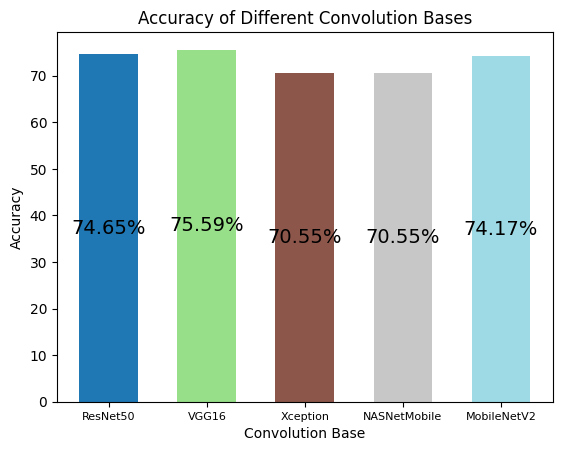

In [11]:
# Define colors for each bar
colors = plt.cm.tab20(np.linspace(0, 1, len(results)))

# Plot the results
fig, ax = plt.subplots()
rects = ax.bar(results.keys(), results.values(), color=colors, width=0.6)
ax.set_title('Accuracy of Different Convolution Bases')
ax.set_xlabel('Convolution Base')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(results.keys(), fontsize=8)
for rect, acc in zip(rects, results.values()):
    width = rect.get_width()
    height = rect.get_height()
    x = rect.get_x() + width / 2
    y = rect.get_y() + height / 2
    ax.text(x, y, f'{acc:.2f}%', ha='center', va='center', fontsize=14)
plt.show()